## This notebook is wave propagating in non-reflecting boundary conditions

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
cd(dirname(pwd()))
cd("src")
include("Tools.jl")
include("FiniteDifference.jl")
include("TimeMarching.jl")
include("Initial.jl")
include("Systems.jl")
include("BoundaryCondition.jl")

using ..Tools
using ..FiniteDifference
using ..TimeMarching
using ..Initial
using ..Systems
using ..BoundaryCondition
pwd()

"C:\\Users\\liyux\\github\\thermo-network\\src"

## Parameters for the RHS

In [3]:
P=1;
Ac=1; # unreal
qw=0;

righthand=[0;0;P/Ac*qw]

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

## Initialization (wave)

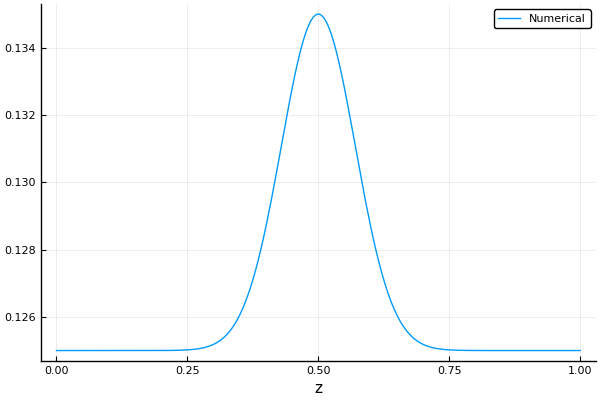

In [16]:
    # Initial spacial variables
    nx = 201   
    gamma = 1.4
    xlim = (0.0,1.0)
    Δx = (xlim[2]-xlim[1])/nx
    ux,uu=Initial.initial_one_wave(nx,xlim,gamma)
#     ux,uu=Initial.initial_sod(nx,xlim,gamma)

    # get every property from the initial uu
    uueverythinginitial=Systems.UUtoEverything(uu,gamma)
    
    # Initial time and storage arrays
    t = 0.0
    thist = []
    uhist = []

 plot(ux,uueverythinginitial.ρ,xlabel="z",label="Numerical")

In [19]:
uu[:,end]

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

## Time Marching (with boundary condition)


In [18]:
    Δt = 0.0001

    println("Δx=",Δx);
    println("Δt=",Δt);



    #Calculation time
    tf = 1Δt
    tsample = Δt;
    T = Δt:Δt:tf

    # Push it with time!
    for ti in T
        
        t, uu = TimeMarching.stegerwarmingrk1!(t,uu,righthand,ShockTubeSystem(gamma,Δt,Δx))
        
        uu[:,end]=set_outlet_nonreflect_boundary!(uu::Array,uueverythinginitial,Δx::Float64,Δt::Float64)
    
        # get every property from uu in every time step
        uueverything=Systems.UUtoEverything(uu,gamma)
    
    
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(thist,deepcopy(t)) : nothing
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(uueverything)) : nothing
    end
    

Δx=0.004975124378109453
Δt=0.0001
gamma=1.4
uu=0.0


MethodError: MethodError: no method matching lastindex(::UUtoEverything)
Closest candidates are:
  lastindex(!Matched::Core.SimpleVector) at essentials.jl:599
  lastindex(!Matched::Cmd) at process.jl:639
  lastindex(!Matched::Base64.Buffer) at C:\Users\julia\AppData\Local\Julia-1.3.1\share\julia\stdlib\v1.3\Base64\src\buffer.jl:19
  ...

In [6]:
plot(ux,uhist[10].p,xlabel="z",ylabel="u",label="Numerical")

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [10]

In [7]:
uu[:,end-11]

3-element Array{Float64,1}:
 0.12500000002542422
 0.1250000000257222 
 2.562500000075336  

In [8]:
 λ = Array{Float64,2}(UndefInitializer(), 5,3)

5×3 Array{Float64,2}:
 4.94066e-324  4.94066e-324  3.06321e-322
 1.56125e-321  1.50339e-315  3.45846e-323
 4.99006e-322  2.07508e-322  1.53888e-315
 4.94066e-324  2.96439e-323  3.52876e-315
 4.44659e-323  4.99208e-316  3.52876e-315

In [9]:
L=get_L_from_nonreflect_h!(uu::Array,uueverythinginitial,Δx::Float64)

d2=get_d_from_L(uu::Array,uueverythinginitial,L::Array)


UndefVarError: UndefVarError: get_L_from_nonreflect_h! not defined

In [10]:
function get_L_from_nonreflect(uu::Array,everythinginitial,Δx::Float64)
        
        # import variables
        gamma = everythinginitial.gamma


        uueverything = UUtoEverything(uu,gamma)

        u = uueverything.u
        ρ = uueverything.ρ
        c = uueverything.c
        p = uueverything.p
        
        # get λ1,λ2,λ3,λ4,λ5
        λ = Array{Float64,1}(UndefInitializer(), 5)
        λ[1] = u[end]-c[end]
        λ[2] = u[end]
        λ[3] = u[end]
        λ[4] = u[end]
        λ[5] = u[end]+c[end]

        # get L1,L2,L3,L4,L5
        L = Array{Float64,1}(UndefInitializer(), 5)
        L[1]=λ[1].*0
        L[2]=λ[2].*(c[end].^2 .* (ρ[end]-ρ[end-1])./Δx-(p[end]-p[end-1])./Δx)
        L[3]=λ[3].*0
        L[4]=λ[4].*0
        L[5]=λ[5].*((p[end]-p[end-1])./Δx+ρ[end].*c[end].*(u[end]-u[end-1])./Δx)

    return L
    end

get_L_from_nonreflect (generic function with 1 method)

In [11]:
function get_d_from_L(uu::Array,everythinginitial,L::Array)
        
        # import variables
        gamma = everythinginitial.gamma


        uueverything = UUtoEverything(uu,gamma)

        u = uueverything.u
        ρ = uueverything.ρ
        c = uueverything.c
        p = uueverything.p
        
        # get d1,d2,d3,d4,d5
        d = Array{Float64}(UndefInitializer(), 5)
        d[1] = 1 ./ (c[end].^2).*(L[2]+0.5.*(L[5]+L[1]))
        d[2] = 0.5 .* (L[5]+L[1])
        d[3] = 0.5 ./ρ[end]./c[end] .* (L[5]-L[1])
        d[4] = 0
        d[5] = 0

    return d
    end

get_d_from_L (generic function with 1 method)

In [12]:
function set_outlet_nonreflect_boundary!(uu::Array,everythinginitial,Δx::Float64,Δt::Float64)


        L = get_L_from_nonreflect(uu,everythinginitial,Δx)
        d = get_d_from_L(uu,everythinginitial,L)

        gamma = everythinginitial.gamma
        h = everythinginitial.h

        uueverything = UUtoEverything(uu,gamma)

        u = uueverything.u
        ρ = uueverything.ρ

        uuend=Array{Float64,1}(UndefInitializer(), 3)
        uuend[1]=uu[1,end] + (-d[1]).*Δt
        uuend[2]=uu[2,end] + (-u[end].*d[1]-ρ[end].*d[3]+0).*Δt
        uuend[3]=uu[3,end] + (-0.5 .* u[end].*u[end].*d[1]-d[2]./(gamma-1) - ρ[end].*u[end].*d[3] + 0).*Δt

    return uuend
    end

ErrorException: error in method definition: function BoundaryCondition.set_outlet_nonreflect_boundary! must be explicitly imported to be extended